# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

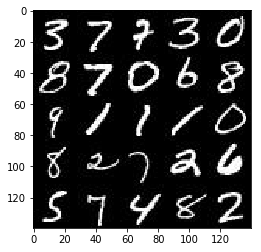

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
import numpy as np
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

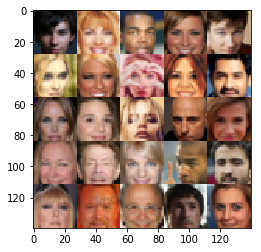

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator',reuse=reuse):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # 
        logits = tf.image.resize_images(logits, (28, 28))
        out = tf.tanh(logits)
        
        return out

    
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = np.array(helper.images_square_grid(samples, image_mode))
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    samples, losses = [], []
    print_every = 10
    show_every = 100
    steps = 0
    n_examples, w, h, d = data_shape
    input_real, input_z, learning_rate_input = model_inputs(w,h,d,z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1,+1,(batch_size,z_dim))
                batch_images = batch_images * 2.0 
                _ = sess.run(d_opt, feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_input:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images,input_z:batch_z,learning_rate_input:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, d, data_image_mode)
    
    
 
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1128... Generator Loss: 2.5530
Epoch 1/2... Discriminator Loss: 0.0325... Generator Loss: 4.0265
Epoch 1/2... Discriminator Loss: 0.0369... Generator Loss: 4.2448
Epoch 1/2... Discriminator Loss: 0.1308... Generator Loss: 2.3725
Epoch 1/2... Discriminator Loss: 0.0198... Generator Loss: 11.7227
Epoch 1/2... Discriminator Loss: 0.0491... Generator Loss: 3.4822
Epoch 1/2... Discriminator Loss: 0.0759... Generator Loss: 5.7485
Epoch 1/2... Discriminator Loss: 0.0965... Generator Loss: 3.8696
Epoch 1/2... Discriminator Loss: 0.5126... Generator Loss: 1.2935
Epoch 1/2... Discriminator Loss: 0.2746... Generator Loss: 4.0100


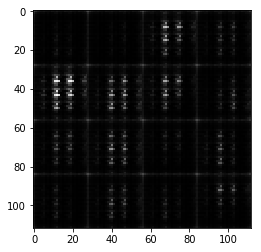

Epoch 1/2... Discriminator Loss: 0.2960... Generator Loss: 2.9552
Epoch 1/2... Discriminator Loss: 0.4479... Generator Loss: 2.6492
Epoch 1/2... Discriminator Loss: 0.2240... Generator Loss: 1.9186
Epoch 1/2... Discriminator Loss: 0.4416... Generator Loss: 2.1959
Epoch 1/2... Discriminator Loss: 0.1403... Generator Loss: 2.6728
Epoch 1/2... Discriminator Loss: 0.2730... Generator Loss: 2.4334
Epoch 1/2... Discriminator Loss: 0.2779... Generator Loss: 1.8972
Epoch 1/2... Discriminator Loss: 0.1264... Generator Loss: 3.2366
Epoch 1/2... Discriminator Loss: 0.2898... Generator Loss: 2.6417
Epoch 1/2... Discriminator Loss: 0.2380... Generator Loss: 3.5565


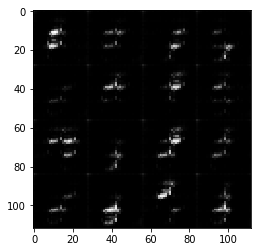

Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 4.9454
Epoch 1/2... Discriminator Loss: 0.4809... Generator Loss: 2.0825
Epoch 1/2... Discriminator Loss: 0.3982... Generator Loss: 1.6894
Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 2.7692
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 3.6131
Epoch 1/2... Discriminator Loss: 0.1972... Generator Loss: 2.9239
Epoch 1/2... Discriminator Loss: 0.3301... Generator Loss: 2.3585
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 1.5808
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 4.3529
Epoch 1/2... Discriminator Loss: 0.6155... Generator Loss: 1.5399


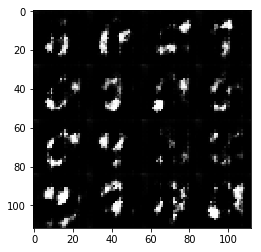

Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 0.5015... Generator Loss: 2.3323
Epoch 1/2... Discriminator Loss: 0.8178... Generator Loss: 2.7075
Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.3712
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 4.4376
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 1.0348
Epoch 1/2... Discriminator Loss: 0.6088... Generator Loss: 1.3645
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 1.8978
Epoch 1/2... Discriminator Loss: 0.4809... Generator Loss: 1.7429
Epoch 1/2... Discriminator Loss: 0.6441... Generator Loss: 1.5740


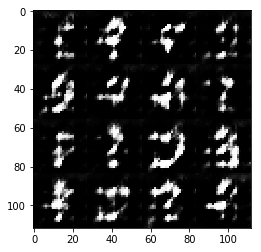

Epoch 1/2... Discriminator Loss: 0.3630... Generator Loss: 2.5557
Epoch 1/2... Discriminator Loss: 0.5127... Generator Loss: 1.5693
Epoch 1/2... Discriminator Loss: 0.5368... Generator Loss: 2.2972
Epoch 1/2... Discriminator Loss: 0.6694... Generator Loss: 1.9445
Epoch 1/2... Discriminator Loss: 0.3629... Generator Loss: 1.9404
Epoch 1/2... Discriminator Loss: 0.6325... Generator Loss: 1.4224
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 2.8208
Epoch 1/2... Discriminator Loss: 0.5871... Generator Loss: 1.4331
Epoch 1/2... Discriminator Loss: 0.7488... Generator Loss: 3.9215
Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 1.1513


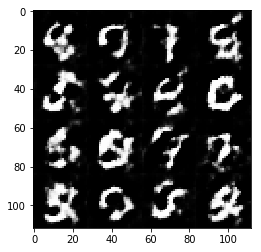

Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.9502
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 3.8989
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 1.6123
Epoch 1/2... Discriminator Loss: 0.5219... Generator Loss: 2.6095
Epoch 1/2... Discriminator Loss: 0.7795... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 2.3134
Epoch 1/2... Discriminator Loss: 0.6488... Generator Loss: 1.3830
Epoch 1/2... Discriminator Loss: 0.5631... Generator Loss: 1.8741
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 1.5373


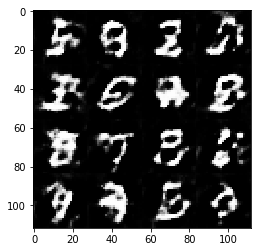

Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 1.9474
Epoch 1/2... Discriminator Loss: 0.5447... Generator Loss: 1.5769
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 1.5107
Epoch 1/2... Discriminator Loss: 0.6133... Generator Loss: 2.2025
Epoch 1/2... Discriminator Loss: 0.6752... Generator Loss: 1.6396
Epoch 1/2... Discriminator Loss: 0.6903... Generator Loss: 1.5294
Epoch 1/2... Discriminator Loss: 0.6102... Generator Loss: 1.8091
Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.3183
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 1.2998
Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 2.3103


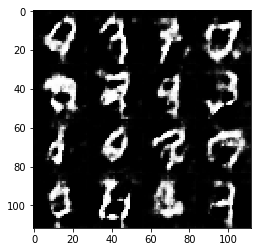

Epoch 1/2... Discriminator Loss: 0.4837... Generator Loss: 1.9383
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 0.5984... Generator Loss: 1.2929
Epoch 1/2... Discriminator Loss: 0.5194... Generator Loss: 1.6373
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 1.7538
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 1.3478
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 1.7092
Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 1.5298
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.6027


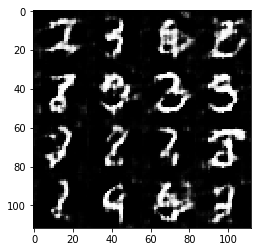

Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 0.9732
Epoch 1/2... Discriminator Loss: 0.5692... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.7423
Epoch 1/2... Discriminator Loss: 0.7137... Generator Loss: 1.7567
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.0085
Epoch 1/2... Discriminator Loss: 0.4735... Generator Loss: 1.5869
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 1.3011
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 0.9875
Epoch 1/2... Discriminator Loss: 1.7776... Generator Loss: 0.2896
Epoch 1/2... Discriminator Loss: 0.8262... Generator Loss: 1.4407


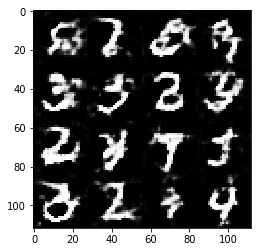

Epoch 1/2... Discriminator Loss: 0.6502... Generator Loss: 1.4521
Epoch 1/2... Discriminator Loss: 0.6301... Generator Loss: 1.3346
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.5626
Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 1.5133
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.6307
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 0.8598
Epoch 1/2... Discriminator Loss: 0.5592... Generator Loss: 2.3314
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 0.8759
Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 1.2279


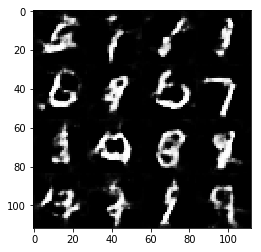

Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 1.6040
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.1845
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 1.2316
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.7793
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 1.4750
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 1.0235
Epoch 1/2... Discriminator Loss: 0.6813... Generator Loss: 1.2976
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.2802
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 2.2625


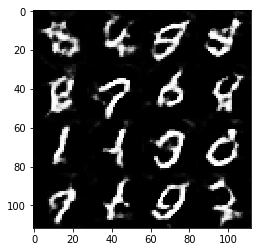

Epoch 1/2... Discriminator Loss: 0.7269... Generator Loss: 1.0132
Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 0.7895... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 0.6695
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 3.1994
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 1.3507
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 1.5662


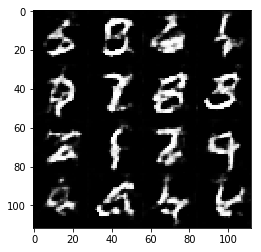

Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 0.9436
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.3169
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 1.4818... Generator Loss: 0.3735
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 1.6102
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.5620
Epoch 1/2... Discriminator Loss: 0.4703... Generator Loss: 1.6152
Epoch 1/2... Discriminator Loss: 1.5495... Generator Loss: 0.3150
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.0081


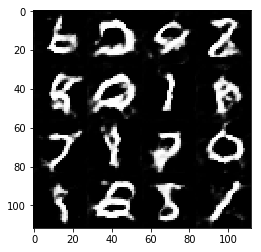

Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 1.3806
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 0.5893... Generator Loss: 1.7514
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 1.6668
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 0.9267
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 0.9414
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 0.8523
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 1.1076


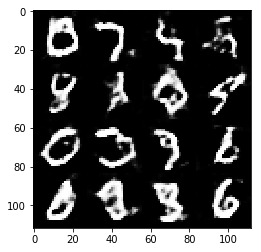

Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 1.8207
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 0.9249
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 1.3493
Epoch 1/2... Discriminator Loss: 0.6549... Generator Loss: 1.4830
Epoch 1/2... Discriminator Loss: 0.6268... Generator Loss: 1.9162
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 1.3483
Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 1.5069
Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 0.5155... Generator Loss: 1.3365


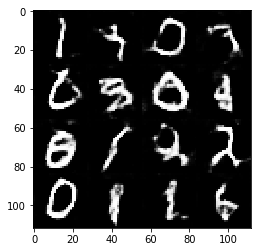

Epoch 1/2... Discriminator Loss: 0.5570... Generator Loss: 1.3210
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 2.1118
Epoch 1/2... Discriminator Loss: 0.6243... Generator Loss: 1.2753
Epoch 1/2... Discriminator Loss: 0.6392... Generator Loss: 2.0698
Epoch 1/2... Discriminator Loss: 0.6100... Generator Loss: 1.2098
Epoch 1/2... Discriminator Loss: 0.6462... Generator Loss: 1.0969
Epoch 1/2... Discriminator Loss: 0.5757... Generator Loss: 1.1399
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.2401
Epoch 1/2... Discriminator Loss: 5.1442... Generator Loss: 6.2061
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 1.0184


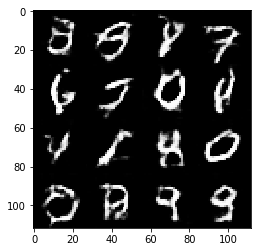

Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 1.3308
Epoch 1/2... Discriminator Loss: 0.4749... Generator Loss: 1.6247
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 0.5190... Generator Loss: 1.4352
Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 1.7361
Epoch 1/2... Discriminator Loss: 1.4383... Generator Loss: 0.3398
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.4576
Epoch 1/2... Discriminator Loss: 0.4660... Generator Loss: 1.6527
Epoch 1/2... Discriminator Loss: 0.5451... Generator Loss: 1.2652
Epoch 1/2... Discriminator Loss: 0.5566... Generator Loss: 2.0270


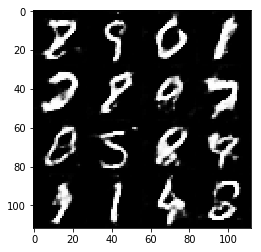

Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 0.6139... Generator Loss: 1.1444
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 0.5208... Generator Loss: 1.4101
Epoch 1/2... Discriminator Loss: 0.5636... Generator Loss: 1.3487
Epoch 1/2... Discriminator Loss: 0.5279... Generator Loss: 1.2026
Epoch 1/2... Discriminator Loss: 0.3784... Generator Loss: 1.6617
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.4565
Epoch 1/2... Discriminator Loss: 0.4843... Generator Loss: 1.4088
Epoch 1/2... Discriminator Loss: 0.7045... Generator Loss: 0.9519


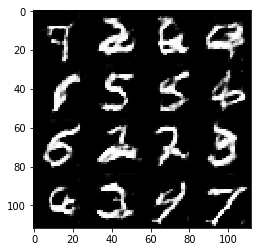

Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 0.9617
Epoch 1/2... Discriminator Loss: 0.5227... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 3.2009... Generator Loss: 0.0830
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.6201
Epoch 1/2... Discriminator Loss: 0.8110... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 1.2228
Epoch 1/2... Discriminator Loss: 0.6299... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.3802
Epoch 2/2... Discriminator Loss: 0.4809... Generator Loss: 1.5241
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.7792


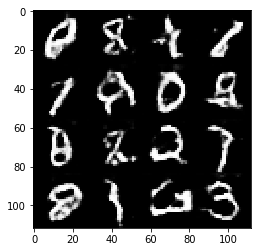

Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 0.4233... Generator Loss: 1.8169
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 0.6161... Generator Loss: 1.2118
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.1536
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 1.1435


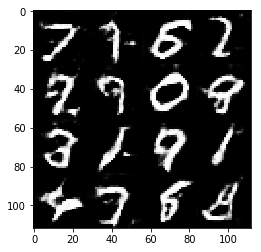

Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 0.9933
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 0.9299
Epoch 2/2... Discriminator Loss: 0.3888... Generator Loss: 1.4380
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 0.9323
Epoch 2/2... Discriminator Loss: 0.5468... Generator Loss: 2.0636
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 0.3686... Generator Loss: 2.5192
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 1.0550
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 1.5251


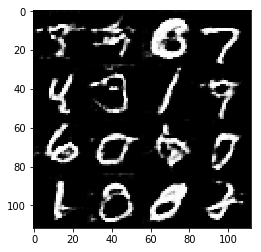

Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 1.3614
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 0.8991
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.5889
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 1.3467
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 1.6453
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 0.4661... Generator Loss: 1.3616
Epoch 2/2... Discriminator Loss: 0.2413... Generator Loss: 2.1740


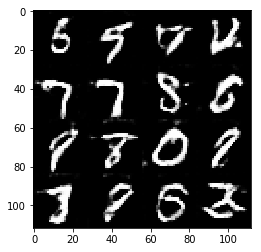

Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 0.9068
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 3.2960
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 2.1949
Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 1.2650
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.1290
Epoch 2/2... Discriminator Loss: 0.5988... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 1.3722
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 2.0759
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 1.5206


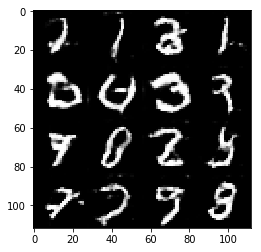

Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.5325
Epoch 2/2... Discriminator Loss: 0.4192... Generator Loss: 1.7275
Epoch 2/2... Discriminator Loss: 0.6468... Generator Loss: 1.0370
Epoch 2/2... Discriminator Loss: 0.6377... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 0.9606
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.3268
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.3335
Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 0.9455
Epoch 2/2... Discriminator Loss: 0.6428... Generator Loss: 1.0731


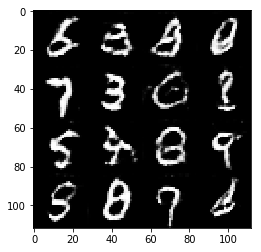

Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 1.4001
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 1.2789
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 0.4878... Generator Loss: 1.5255
Epoch 2/2... Discriminator Loss: 0.5900... Generator Loss: 1.2787
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 0.9136
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 0.3861
Epoch 2/2... Discriminator Loss: 0.6176... Generator Loss: 1.1911
Epoch 2/2... Discriminator Loss: 2.0370... Generator Loss: 0.1938


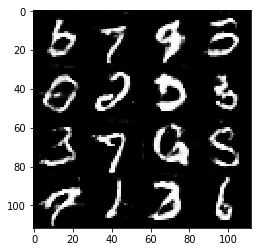

Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.4767
Epoch 2/2... Discriminator Loss: 0.6103... Generator Loss: 1.0748
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 1.1892
Epoch 2/2... Discriminator Loss: 0.6660... Generator Loss: 2.1518
Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 0.9563
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.1536
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.0675
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 1.1417
Epoch 2/2... Discriminator Loss: 1.8932... Generator Loss: 0.2580


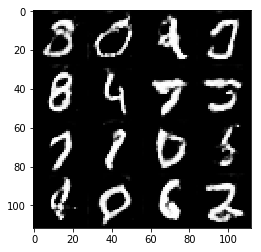

Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 0.4159... Generator Loss: 1.7674
Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 2.3913
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 0.3868... Generator Loss: 1.6204
Epoch 2/2... Discriminator Loss: 0.3375... Generator Loss: 2.1141
Epoch 2/2... Discriminator Loss: 0.3929... Generator Loss: 2.0333
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 0.9226
Epoch 2/2... Discriminator Loss: 1.7777... Generator Loss: 4.6606


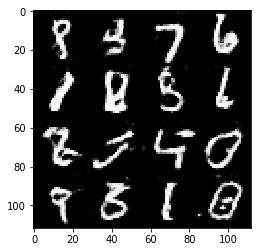

Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 0.3183... Generator Loss: 2.0403
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 1.6864
Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.4868
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 2.5032
Epoch 2/2... Discriminator Loss: 0.3592... Generator Loss: 2.7134
Epoch 2/2... Discriminator Loss: 0.7125... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 0.9534
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.4370


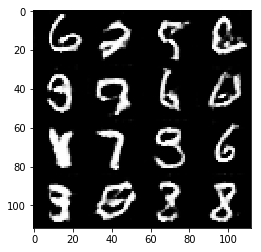

Epoch 2/2... Discriminator Loss: 0.4889... Generator Loss: 1.3204
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 1.0973
Epoch 2/2... Discriminator Loss: 0.5345... Generator Loss: 1.3978
Epoch 2/2... Discriminator Loss: 2.3642... Generator Loss: 0.2066
Epoch 2/2... Discriminator Loss: 0.3807... Generator Loss: 1.8874
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 0.4210... Generator Loss: 1.5921
Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 1.1556
Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 0.4810... Generator Loss: 1.5023


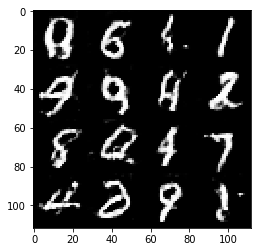

Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 1.8666
Epoch 2/2... Discriminator Loss: 0.9881... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 0.4580... Generator Loss: 1.6540
Epoch 2/2... Discriminator Loss: 0.9468... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 0.3094... Generator Loss: 1.7586
Epoch 2/2... Discriminator Loss: 0.5390... Generator Loss: 1.4559
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 0.6180
Epoch 2/2... Discriminator Loss: 0.4272... Generator Loss: 2.9160
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.5222
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 0.8236


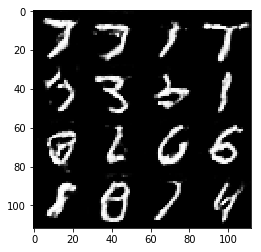

Epoch 2/2... Discriminator Loss: 0.4324... Generator Loss: 1.4043
Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 0.9201
Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 2.8876
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.5816
Epoch 2/2... Discriminator Loss: 0.3585... Generator Loss: 1.7230
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.1208
Epoch 2/2... Discriminator Loss: 0.3285... Generator Loss: 2.1224
Epoch 2/2... Discriminator Loss: 0.6591... Generator Loss: 1.2727


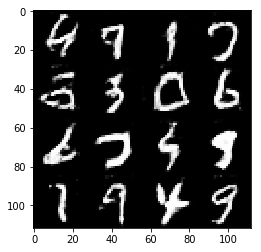

Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 0.7534... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 0.3345... Generator Loss: 1.7585
Epoch 2/2... Discriminator Loss: 0.5025... Generator Loss: 1.2880
Epoch 2/2... Discriminator Loss: 0.2727... Generator Loss: 2.1420
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 1.3029
Epoch 2/2... Discriminator Loss: 0.3993... Generator Loss: 1.9491
Epoch 2/2... Discriminator Loss: 0.3421... Generator Loss: 1.8746
Epoch 2/2... Discriminator Loss: 0.3843... Generator Loss: 1.6917
Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 0.9551


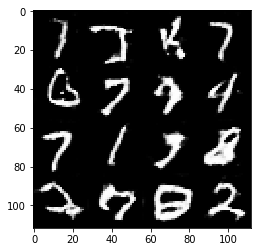

Epoch 2/2... Discriminator Loss: 0.3986... Generator Loss: 1.5652
Epoch 2/2... Discriminator Loss: 0.6402... Generator Loss: 1.3025
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 1.2740
Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 1.5322
Epoch 2/2... Discriminator Loss: 0.5134... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.6104
Epoch 2/2... Discriminator Loss: 0.5104... Generator Loss: 1.2732
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.4091
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 1.1506
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 1.2224


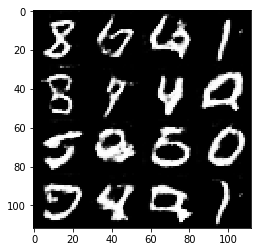

Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 1.1136
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.3848
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 2.1784
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 1.2344
Epoch 2/2... Discriminator Loss: 0.3350... Generator Loss: 2.3365
Epoch 2/2... Discriminator Loss: 0.5339... Generator Loss: 2.0287
Epoch 2/2... Discriminator Loss: 0.3234... Generator Loss: 2.1317
Epoch 2/2... Discriminator Loss: 0.3552... Generator Loss: 2.0424
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 0.7620


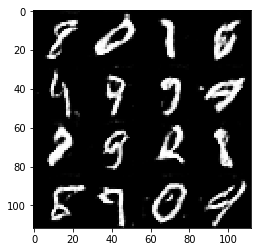

Epoch 2/2... Discriminator Loss: 0.3882... Generator Loss: 1.5711
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 0.9330
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.1981
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 1.8643
Epoch 2/2... Discriminator Loss: 0.2807... Generator Loss: 2.4178
Epoch 2/2... Discriminator Loss: 0.3505... Generator Loss: 1.9830
Epoch 2/2... Discriminator Loss: 0.6236... Generator Loss: 1.2630
Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.4075
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 0.9359


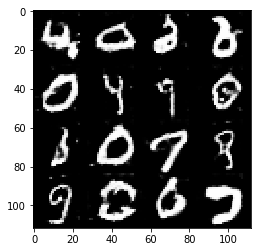

Epoch 2/2... Discriminator Loss: 0.5280... Generator Loss: 1.4073
Epoch 2/2... Discriminator Loss: 1.9944... Generator Loss: 0.2704
Epoch 2/2... Discriminator Loss: 0.4776... Generator Loss: 1.6544
Epoch 2/2... Discriminator Loss: 0.4279... Generator Loss: 1.7508
Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 1.6925
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 0.5029
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.2172
Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 1.4116
Epoch 2/2... Discriminator Loss: 0.4190... Generator Loss: 1.4834
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 2.3997


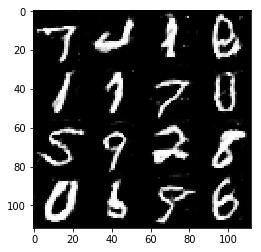

Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 2.3942
Epoch 2/2... Discriminator Loss: 0.8327... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 0.4879... Generator Loss: 1.3047
Epoch 2/2... Discriminator Loss: 0.6064... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 0.6100... Generator Loss: 1.0470
Epoch 2/2... Discriminator Loss: 0.7764... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 0.5359... Generator Loss: 1.4271
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.3956


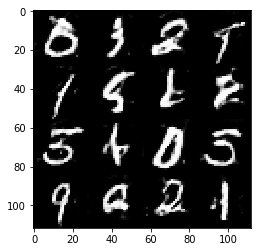

Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 1.3870
Epoch 2/2... Discriminator Loss: 0.5902... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 0.6581... Generator Loss: 1.0087
Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 1.1616


In [15]:
batch_size = 32
z_dim = 125
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.3254... Generator Loss: 2.1471
Epoch 1/2... Discriminator Loss: 0.2404... Generator Loss: 1.8836
Epoch 1/2... Discriminator Loss: 0.1034... Generator Loss: 3.3945
Epoch 1/2... Discriminator Loss: 0.1884... Generator Loss: 2.5315
Epoch 1/2... Discriminator Loss: 0.1939... Generator Loss: 2.8592
Epoch 1/2... Discriminator Loss: 2.8541... Generator Loss: 13.6288
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 2.2498
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 0.7947


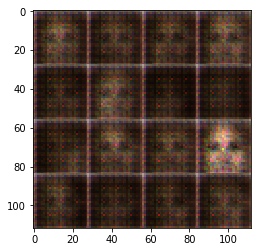

Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 2.3574
Epoch 1/2... Discriminator Loss: 0.9358... Generator Loss: 1.6169
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.4354
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 1.8995
Epoch 1/2... Discriminator Loss: 1.7498... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.0902
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 1.1355
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 0.7866


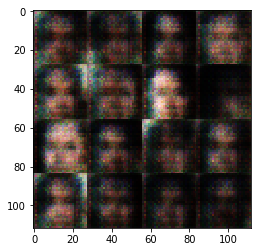

Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 1.6512
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 0.9535
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 1.9909
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.9720
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 1.2459
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 1.2999
Epoch 1/2... Discriminator Loss: 0.7259... Generator Loss: 1.6320
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.6189


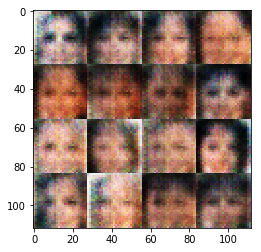

Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 1.4422
Epoch 1/2... Discriminator Loss: 1.5982... Generator Loss: 1.0292
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 1.0965
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 0.6194
Epoch 1/2... Discriminator Loss: 1.4565... Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 1.0030... Generator Loss: 1.7383
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.5947


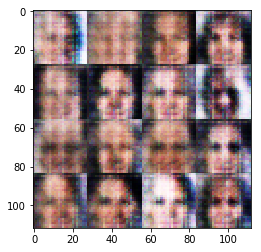

Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.7970
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.2737
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 1.2802
Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 0.9438
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 1.4759
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.7998


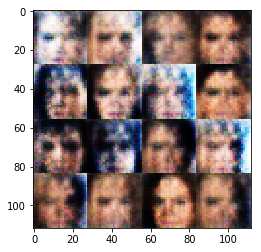

Epoch 1/2... Discriminator Loss: 1.5149... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.4555
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.5422
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 1.0136
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.1079... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.9486


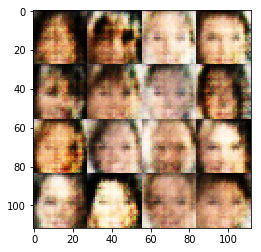

Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.5615
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 0.6148
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.7794


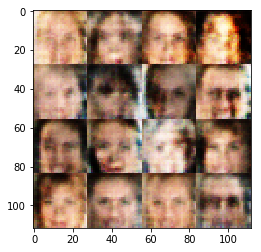

Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.6577
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 1.5664... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 1.2157
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.8237


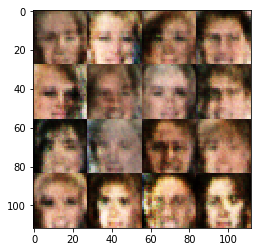

Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.9470
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.8443
Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.8554


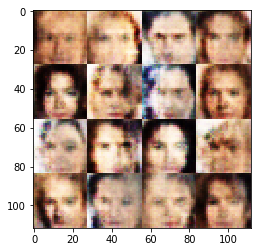

Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 1.1548
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 1.0376
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 0.9551
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.5257


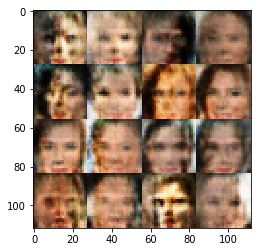

Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.8353
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.0197
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.7346
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 1.1392
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.8307


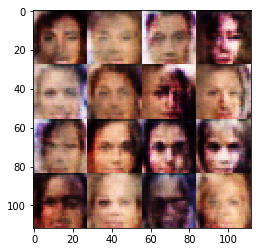

Epoch 1/2... Discriminator Loss: 1.2679... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.7027
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.4809... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 0.8572


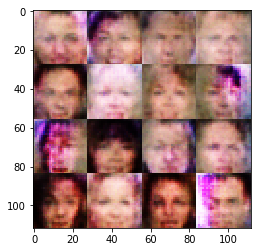

Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.5966
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.0600... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.6702
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.6782


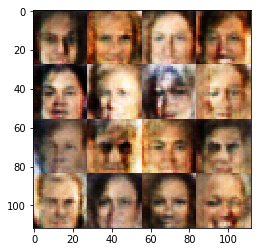

Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 1.5419... Generator Loss: 0.4342
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 1.1494... Generator Loss: 0.7953
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 0.8854
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.7121


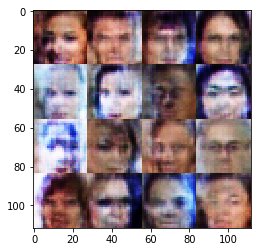

Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.7530
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.6728
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.6028
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 0.7583


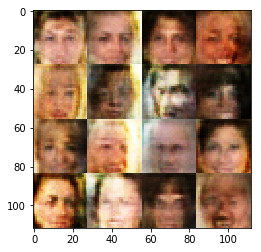

Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.4633
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.1053
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.4300
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.9733


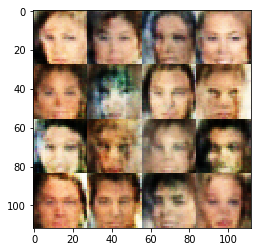

Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.5461
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 1.3465... Generator Loss: 0.6308


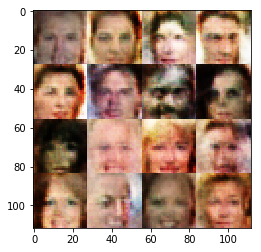

Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.5540
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.7175
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.7942


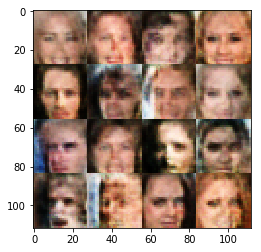

Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.5396
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.5896
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.7053


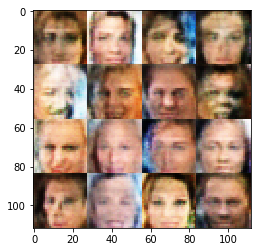

Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.9863
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 1.1759
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.0273... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.5633
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.6492


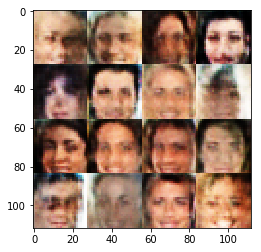

Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 1.1034
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 1.0972
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.5481
Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 0.9955
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.3279
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 0.8303
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.0136
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 0.7930


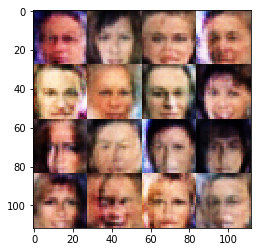

Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.9968
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.9440


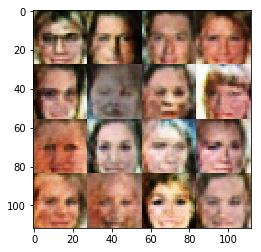

Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 0.7792
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.5105
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 1.1490... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.6078... Generator Loss: 0.3779
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.6051


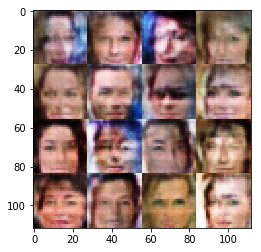

Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.6745


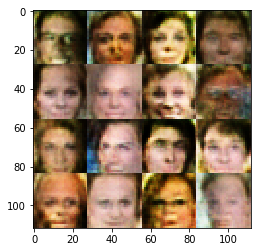

Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.8782
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.6434
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.6408
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.5967
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.4673


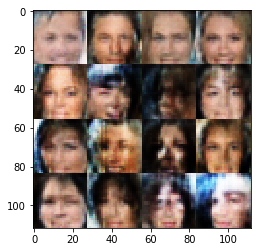

Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 0.5685
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.4831
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.1625... Generator Loss: 0.7429


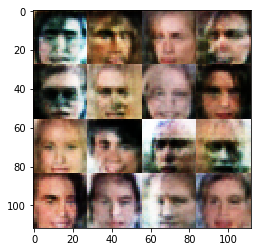

Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.1546
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.7189
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.6062
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.8769
Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 1.1422


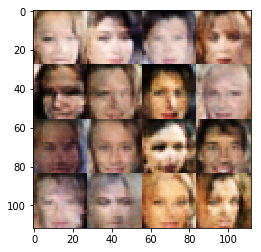

Epoch 1/2... Discriminator Loss: 0.9396... Generator Loss: 0.9431
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 0.7340
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.9667
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.8603


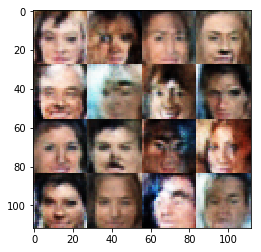

Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.7027
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.9447
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.6033


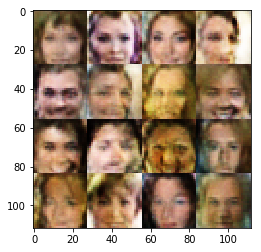

Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 0.4799
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 0.7815


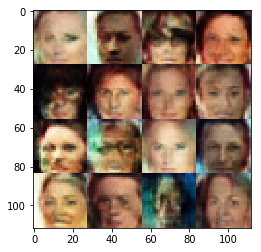

Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 0.4666
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.5603
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.8476
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 1.0217
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.7523
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 0.9254


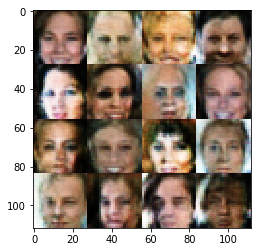

Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 1.5288... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.5020
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 0.9804... Generator Loss: 0.9715
Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 1.4027
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 1.1063


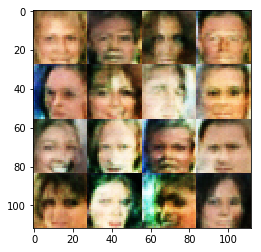

Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.5092
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 0.9073
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.6098
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.6034... Generator Loss: 0.4338
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 1.0507
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.6152


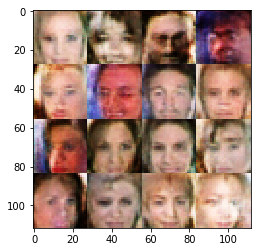

Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.5574


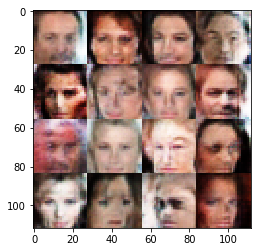

Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.6057
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.6460
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.5496
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.7451


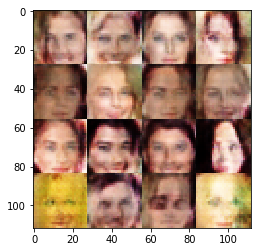

Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.0863... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.5922
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 1.1632
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.0320


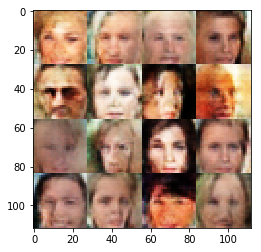

Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 0.6126
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.5125
Epoch 1/2... Discriminator Loss: 1.5348... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.6678
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.6055
Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.5997
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.6234


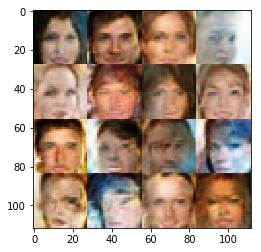

Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 1.0119
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.6098
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 1.1685
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.7201
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.8568
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.6060


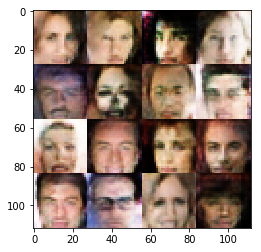

Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.5205
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 0.9100
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.5087
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.4006
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.9263
Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 0.7196


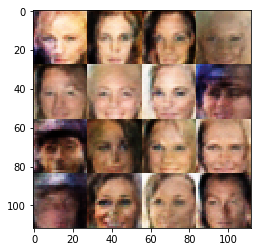

Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.7114
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.5492
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.0909... Generator Loss: 0.9601
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.4285


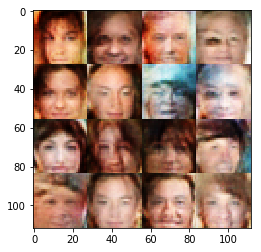

Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 0.9651
Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 1.0633
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.2543... Generator Loss: 0.6167
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.5811
Epoch 1/2... Discriminator Loss: 1.1336... Generator Loss: 0.7659


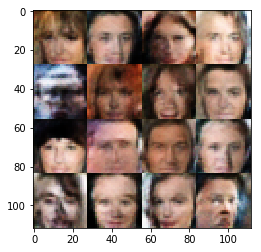

Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.5801
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.8870
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.5043
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.3465... Generator Loss: 0.5475
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.5339


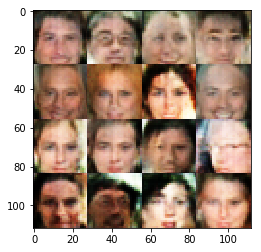

Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.4502
Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 0.5686
Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 0.6759
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 0.7505
Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.7962


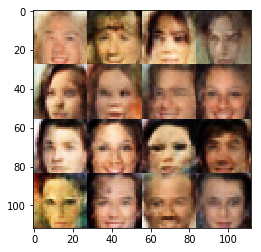

Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.5075... Generator Loss: 0.4458
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 1.6002... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.5946
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.4489


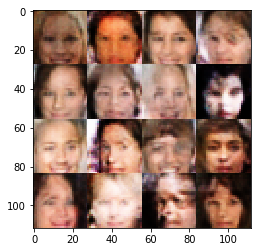

Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 0.8593
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 1.1358... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 0.5194
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.6703


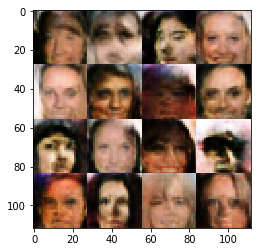

Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.5104
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 0.8403
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 0.8555


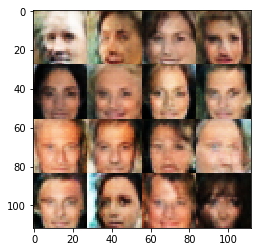

Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.4648... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.4564
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.5435
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.5776
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.6724


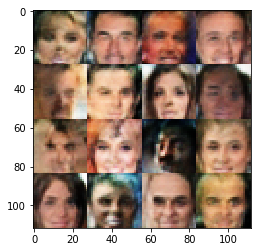

Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 1.1814
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.6759
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.7044


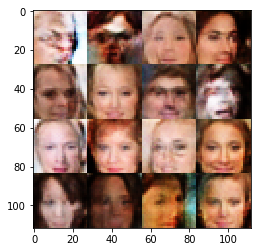

Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.4711
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.7498
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 0.7842
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 0.4485
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.4990
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.4984
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 0.8442


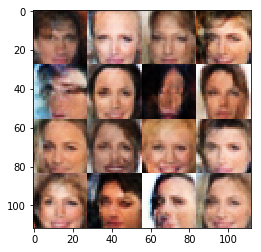

Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 0.9241
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 0.7886
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.6382
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.4914


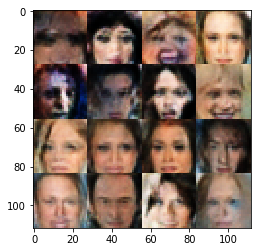

Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.3996
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 0.5697
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.3950
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.7565


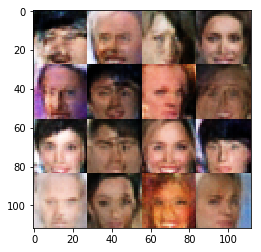

Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 1.0657
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.5184
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.4542
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 0.7073


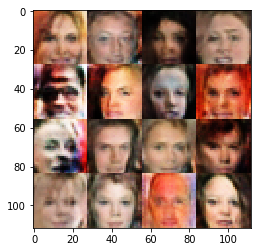

Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 0.4841
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.0723... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 0.6839
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 0.7247


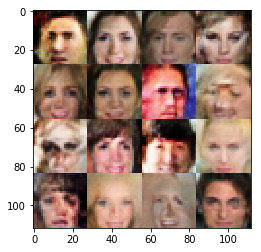

Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.4796
Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.5308
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.4233
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 1.0486
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.5839


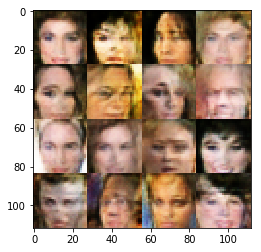

Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.0650
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.5122
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 0.6702
Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.4600


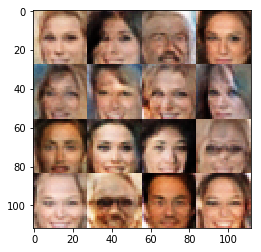

Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.0044
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 0.6518
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 0.8069
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.5799
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 0.8617


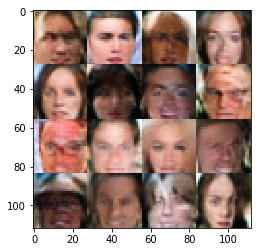

Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.6488
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 1.0660
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 0.8010
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.7188


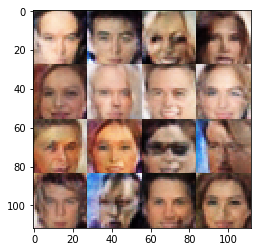

Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.7523
Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.4483
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 0.8982


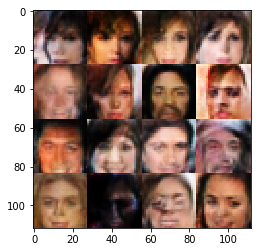

Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.7316
Epoch 1/2... Discriminator Loss: 1.5763... Generator Loss: 0.4323
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 1.1629


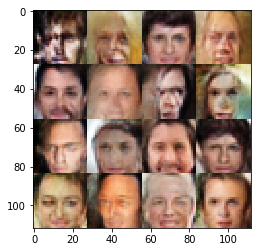

Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.5153
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 1.6838... Generator Loss: 0.4572
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 0.6585


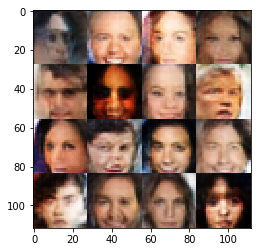

Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.6756
Epoch 1/2... Discriminator Loss: 1.2912... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.5742
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.9402


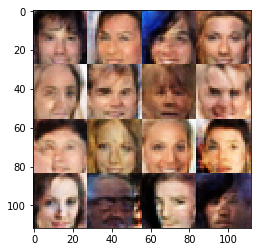

Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.5816
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.5749
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.9558
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.4957
Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 1.2543... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 0.7986


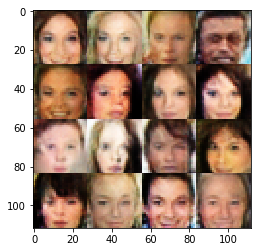

Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.6265
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 1.2717
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.4537
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.9528


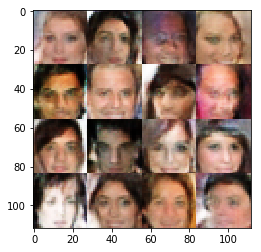

Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 0.9881... Generator Loss: 0.6583
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 0.6734


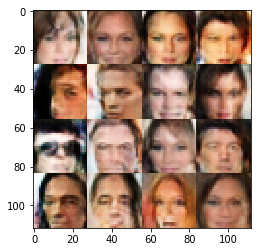

Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.6556
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.5421... Generator Loss: 0.4460
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.7436


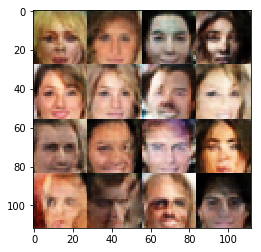

Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.6673
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 0.5953
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.7893
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.0667
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.6969
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.5830
Epoch 2/2... Discriminator Loss: 1.1053... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 1.3057... Generator Loss: 0.5934


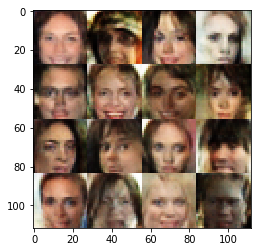

Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 0.4831
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.7106
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 1.1608
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.6650
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.5821
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 1.0645


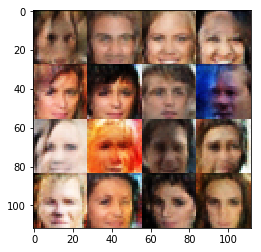

Epoch 2/2... Discriminator Loss: 1.4763... Generator Loss: 0.5007
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 0.9341
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 0.5698
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.5465
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.7057


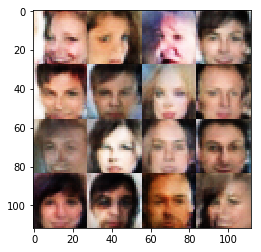

Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 0.9006
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 0.5165
Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 1.0065
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 0.6910


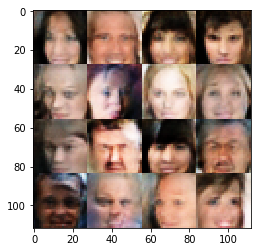

Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.8214
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.4843
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.7738
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.5885... Generator Loss: 0.4221


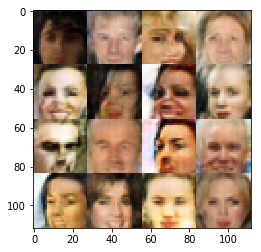

Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.4748
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.6250
Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 0.7489
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 0.8734


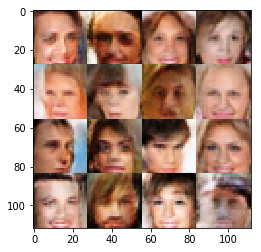

Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.8300
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.4146
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.6152
Epoch 2/2... Discriminator Loss: 1.4504... Generator Loss: 0.5461
Epoch 2/2... Discriminator Loss: 1.3989... Generator Loss: 0.4680
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.6173
Epoch 2/2... Discriminator Loss: 1.0636... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.5416


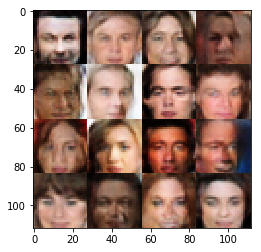

Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.5198
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 1.1896... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.9044


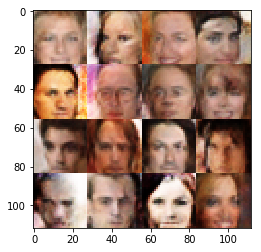

Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.5447
Epoch 2/2... Discriminator Loss: 1.1396... Generator Loss: 0.6398
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.6136
Epoch 2/2... Discriminator Loss: 1.5664... Generator Loss: 0.4426
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.7950


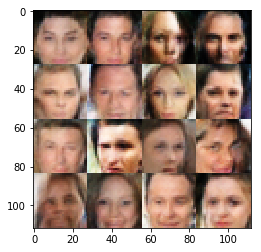

Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 1.3428... Generator Loss: 0.5315
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.3966
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.5321
Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 1.1166... Generator Loss: 0.9703
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.5843
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.6570


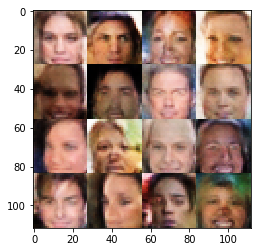

Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.4521... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.8504
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.6124
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.4905
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.1591... Generator Loss: 0.6291


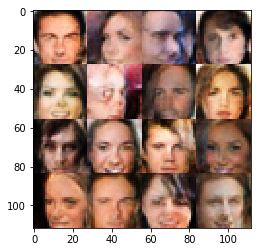

Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.6205
Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 1.6650... Generator Loss: 0.2583
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.5939
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.6595


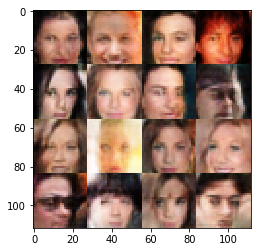

Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.4562... Generator Loss: 0.4242
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.8359
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.6280
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.6404
Epoch 2/2... Discriminator Loss: 1.4226... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.5713
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 0.9232
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.4777


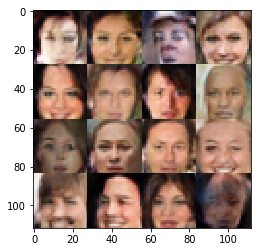

Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.5115
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 0.7376
Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.4713
Epoch 2/2... Discriminator Loss: 1.7667... Generator Loss: 0.3682
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.4665
Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 0.8942


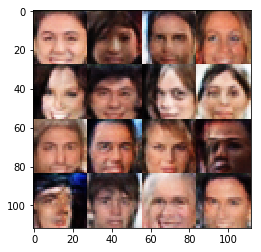

Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 0.8128
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.5554
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 0.9117
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 0.8977
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 0.7530


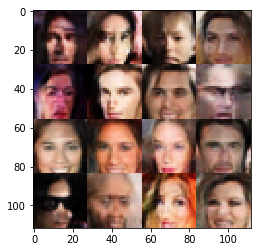

Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 1.4740... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.5930
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.4529
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.5365
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.6905
Epoch 2/2... Discriminator Loss: 1.1409... Generator Loss: 0.6164


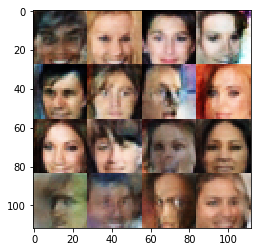

Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.4946
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.6016
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.4460
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.6901
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.3703


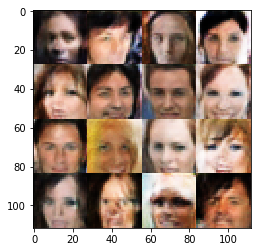

Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.5590
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.9330
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.6497
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.6089
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 0.8236


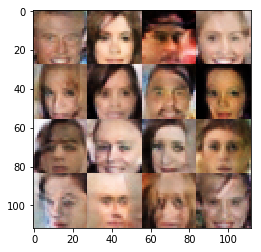

Epoch 2/2... Discriminator Loss: 1.3903... Generator Loss: 0.5321
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.5887
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.6933
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.5223
Epoch 2/2... Discriminator Loss: 1.4638... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 1.1016
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.0690


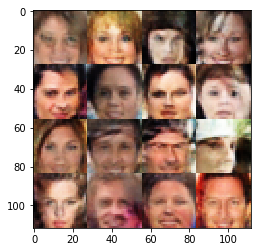

Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.5936
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 0.6901
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 0.9247
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.4797
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.4146
Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.6378


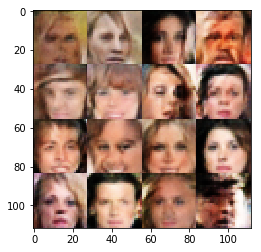

Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.4469
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 0.5766
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.7328
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 1.0169
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.6004


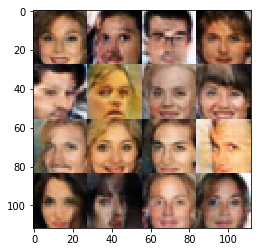

Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 0.6552
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.5595
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.2453... Generator Loss: 0.6484


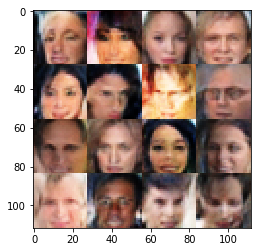

Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.4513
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 1.5020... Generator Loss: 0.4149
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.0907... Generator Loss: 0.8805
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.5652
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 0.4759
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 1.0432


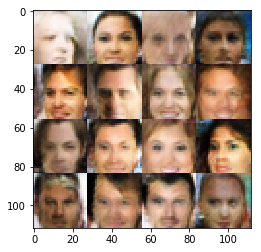

Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.6650
Epoch 2/2... Discriminator Loss: 1.2318... Generator Loss: 0.6052
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.9144
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.5950
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.5609
Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 0.7731


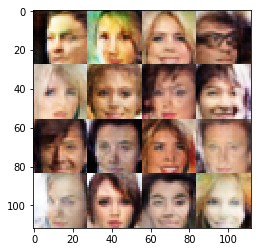

Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 1.5203... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.5606
Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.5157
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.4772... Generator Loss: 0.3977


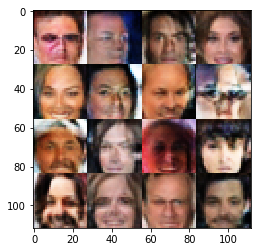

Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.6219
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.7216... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.5189
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 0.6280
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.4918
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 0.5981


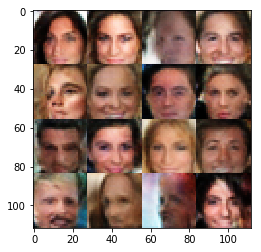

Epoch 2/2... Discriminator Loss: 1.4869... Generator Loss: 0.4598
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 0.7976
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 0.5370
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.6488
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.1776... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 0.5886
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.5213


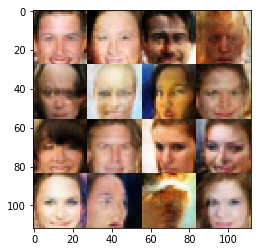

Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.5720
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.5760
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 1.1902... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.4978
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.7540


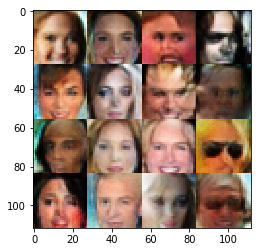

Epoch 2/2... Discriminator Loss: 1.4248... Generator Loss: 0.5421
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.5953
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.6636
Epoch 2/2... Discriminator Loss: 1.5229... Generator Loss: 0.5256
Epoch 2/2... Discriminator Loss: 1.4347... Generator Loss: 0.4721
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.6985
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 0.5905


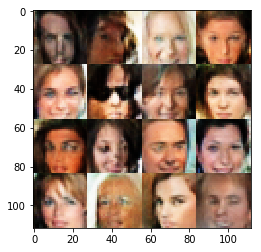

Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 0.9334
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.5951
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.5631


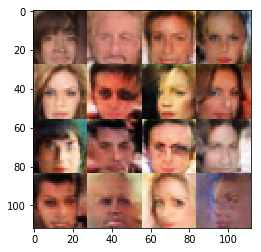

Epoch 2/2... Discriminator Loss: 1.0504... Generator Loss: 0.6463
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.5817
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.4491
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.4368
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 0.7327


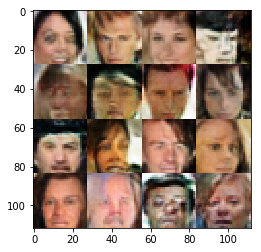

Epoch 2/2... Discriminator Loss: 1.6104... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.5445
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.5175
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.5858
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 0.5729
Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.5564


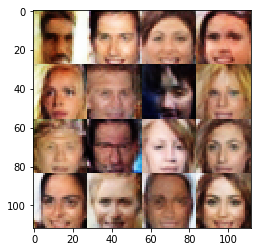

Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.9297
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.4805
Epoch 2/2... Discriminator Loss: 1.4559... Generator Loss: 0.4764
Epoch 2/2... Discriminator Loss: 1.0038... Generator Loss: 0.9384
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.5445
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.6298
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.7952


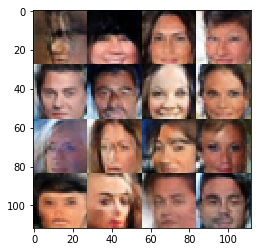

Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 0.9885
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.5414
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 1.1745... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.5387
Epoch 2/2... Discriminator Loss: 1.4282... Generator Loss: 0.5542
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.7468


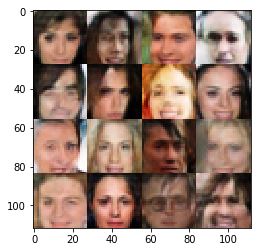

Epoch 2/2... Discriminator Loss: 1.4323... Generator Loss: 0.5382
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.5492
Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.6599
Epoch 2/2... Discriminator Loss: 1.4336... Generator Loss: 0.5956
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 0.5219
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.5824
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 0.6891


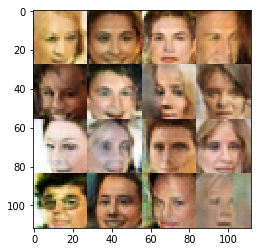

Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 1.5122... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 1.0443
Epoch 2/2... Discriminator Loss: 1.4691... Generator Loss: 0.4203
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.3800
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.6610
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.5383


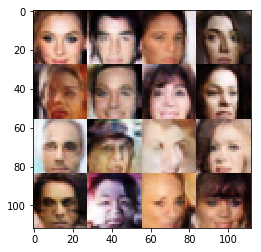

Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.5640
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 1.5417... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 0.9178
Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.6137
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8353
Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 0.8447


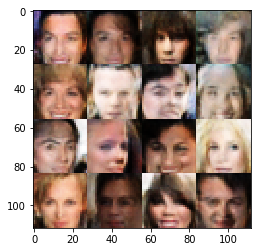

Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.5187
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 0.8375
Epoch 2/2... Discriminator Loss: 1.4663... Generator Loss: 0.5134
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.4528
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.5638
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.3705


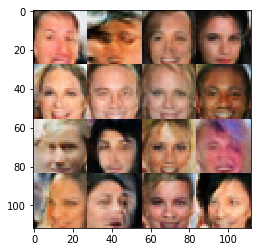

Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.4739
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 0.5023
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.5666
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.6237
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.6361
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.7069
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.6191


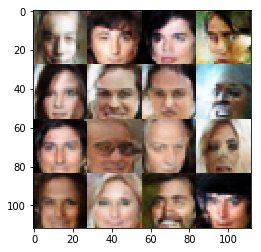

Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.5708
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.8118
Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 0.7503
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.5867
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 1.1524... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.5371


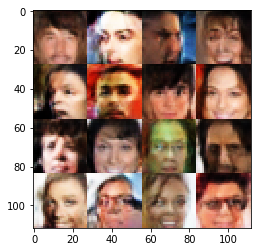

Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.4682
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.7200
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.5326
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.5259
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.5892
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 0.8873
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.8957


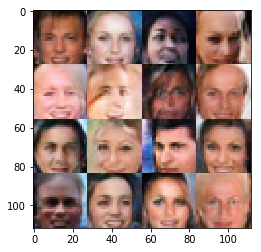

Epoch 2/2... Discriminator Loss: 1.2215... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.4049... Generator Loss: 0.5138
Epoch 2/2... Discriminator Loss: 1.5303... Generator Loss: 0.5182
Epoch 2/2... Discriminator Loss: 1.5016... Generator Loss: 0.4377
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.6090
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.4881


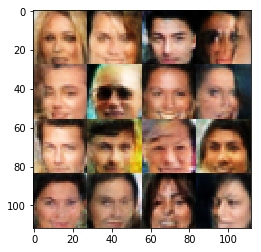

Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 1.4565... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.2140... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.5431
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.4748
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.7479


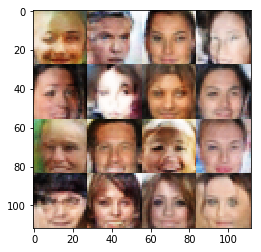

Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.5803
Epoch 2/2... Discriminator Loss: 1.5477... Generator Loss: 0.4220
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.0986... Generator Loss: 0.9430
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.6720


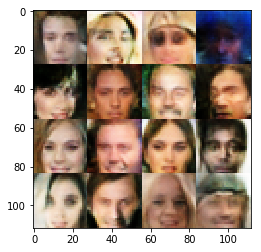

Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.4900
Epoch 2/2... Discriminator Loss: 1.5067... Generator Loss: 0.4629
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.6674
Epoch 2/2... Discriminator Loss: 1.1951... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.5933
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.7686


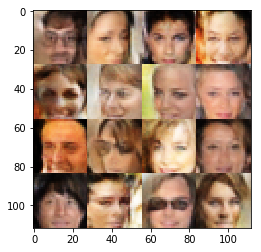

Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 0.4237


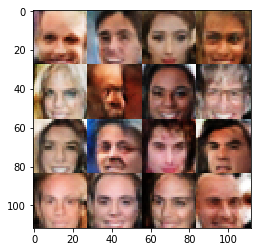

Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.3940
Epoch 2/2... Discriminator Loss: 1.1249... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.4795
Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.5718
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.5723
Epoch 2/2... Discriminator Loss: 1.6467... Generator Loss: 0.3719
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.0614... Generator Loss: 0.8120


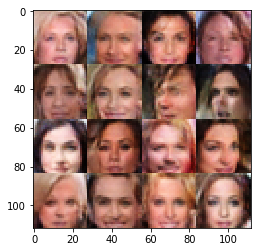

Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 1.2312... Generator Loss: 0.4973
Epoch 2/2... Discriminator Loss: 1.2420... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.1940... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.5087
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.5598


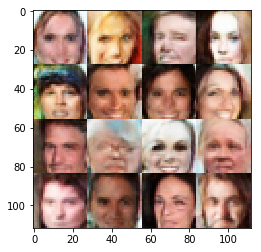

Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.0180... Generator Loss: 0.8272
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.6261
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.0366... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.4949
Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 0.7626


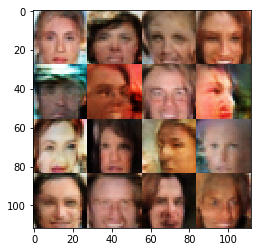

Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 1.0112
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.5088
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.5936
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 0.6759
Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 0.4196
Epoch 2/2... Discriminator Loss: 1.4760... Generator Loss: 0.4310
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 0.6876


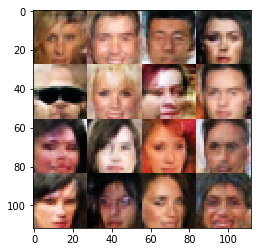

Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 0.9658
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.5857
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.5316
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.4927
Epoch 2/2... Discriminator Loss: 1.1576... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.5204
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 1.4504... Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 0.7489


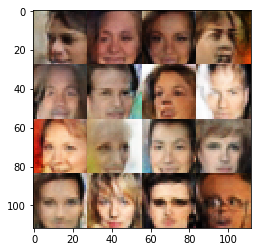

Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 1.5936... Generator Loss: 0.5581
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.5341
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.6939
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.0485... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 0.6094


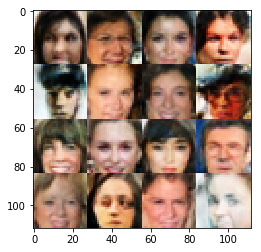

Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.4972
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.5354
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.6310


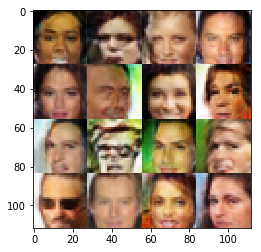

Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.5979
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 0.9001
Epoch 2/2... Discriminator Loss: 1.6274... Generator Loss: 0.4654
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.5476
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 0.7899
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.8553
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.5513
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.6873


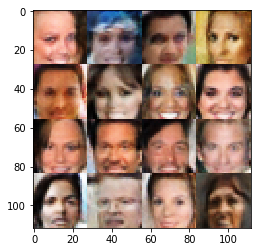

Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.6015
Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.3999
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.5598
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.5911
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.5734
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.6085
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.6591
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.7086


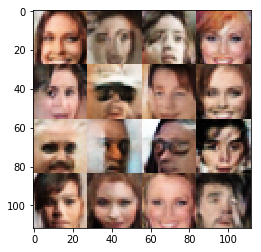

Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.5800
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.4854
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.6185
Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 0.8258


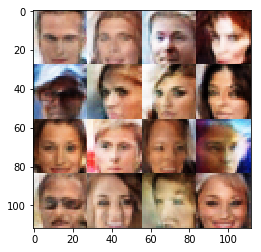

Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 0.6646
Epoch 2/2... Discriminator Loss: 1.1798... Generator Loss: 0.7309
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.5186
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 1.1744... Generator Loss: 0.9734
Epoch 2/2... Discriminator Loss: 1.1576... Generator Loss: 0.6259
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.4659
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.4387
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 0.4813


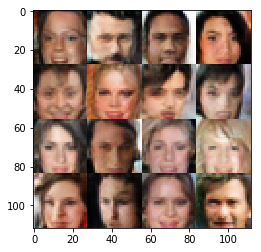

Epoch 2/2... Discriminator Loss: 1.4642... Generator Loss: 0.5036
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.2648... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 1.2775... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.5490
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 0.8168


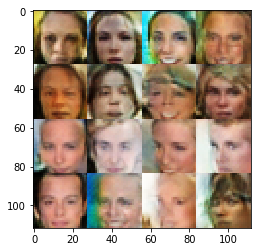

Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.5625
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.5510
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 0.6113


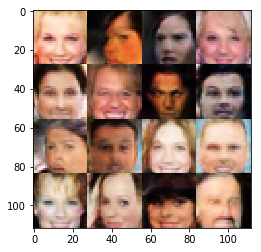

Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.5913
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 0.6990


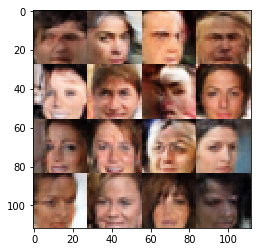

Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.5553
Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.7514
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.5449
Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.7062
Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 1.1211
Epoch 2/2... Discriminator Loss: 1.5159... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 1.4676... Generator Loss: 0.4201
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.6910


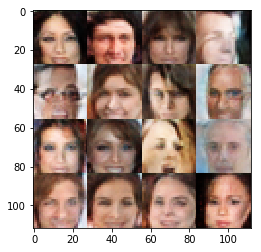

Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 1.5218... Generator Loss: 0.4655
Epoch 2/2... Discriminator Loss: 1.4788... Generator Loss: 0.4872
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 1.1631
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 0.6791


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.